# Effect of Class Length on Grades
Alexander Bailey, Kayli Leung

# Methodology
We will perform a two-tail, two-sample t-test on the data. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses#schedules.csv).

## Question

Is there a significant difference in the percentage of A's given based on the length a class. 

## Hypotheses
We select an alpha value of 0.025.

Null Hypothesis: There is no significant difference in the mean percentage of A's in classes of different lengths.

Alternate Hypothesis: There is a significant difference in the mean percentage of A's in classes of different lengths.

In [51]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(15)

In [31]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [32]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sched.end_time
, sect.section_type
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [33]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count
0,105,1,0,0,0,0,1,-1,-1,FLD,107
1,105,1,0,0,0,0,1,-1,-1,FLD,107
2,111,0,0,0,0,0,0,-1,-1,FLD,111
3,35,0,1,0,0,0,0,960,1010,LAB,36
4,39,1,0,1,0,0,0,725,775,LAB,41


In [34]:
df.sort_values(by='start_time').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count
0,105,1,0,0,0,0,1,-1,-1,FLD,107
117677,0,0,0,0,0,0,0,-1,-1,IND,0
117676,0,0,0,0,0,0,0,-1,-1,IND,0
117675,0,0,0,0,0,0,0,-1,-1,IND,0
117674,0,0,0,0,0,0,0,-1,-1,IND,0


Create column for class length:

In [35]:
df['class_length'] = df['end_time'] - df['start_time']
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
0,105,1,0,0,0,0,1,-1,-1,FLD,107,0
1,105,1,0,0,0,0,1,-1,-1,FLD,107,0
2,111,0,0,0,0,0,0,-1,-1,FLD,111,0
3,35,0,1,0,0,0,0,960,1010,LAB,36,50
4,39,1,0,1,0,0,0,725,775,LAB,41,50


In [36]:
df.loc[df['class_length'] == 0,'section_type'].value_counts()

IND    81726
LEC     4405
FLD     3691
SEM     1345
LAB     1331
DIS       19
Name: section_type, dtype: int64

It appears that all classes with a start and end time of -1 also have a class length of 0, mostly independent studies and other classes lacking a regular schedule. Since these are not useful in our current test, we can drop classes with a length of 0.

In [37]:
df = df[df['class_length'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124882 entries, 3 to 217299
Data columns (total 12 columns):
a_count         124882 non-null int64
ab_count        124882 non-null int64
b_count         124882 non-null int64
bc_count        124882 non-null int64
c_count         124882 non-null int64
d_count         124882 non-null int64
f_count         124882 non-null int64
start_time      124882 non-null int64
end_time        124882 non-null int64
section_type    124882 non-null object
total_count     124882 non-null int64
class_length    124882 non-null int64
dtypes: int64(11), object(1)
memory usage: 12.4+ MB


In [38]:
df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
168718,0,0,0,0,0,0,0,800,900,LEC,0,100
98727,0,0,0,0,0,0,0,800,850,LEC,0,50
98728,0,0,0,0,0,0,0,800,850,LEC,0,50
98729,0,0,0,0,0,0,0,800,850,LEC,0,50
98738,0,0,0,0,0,0,0,1140,1290,LEC,0,150


There are still a number of classes that have no students. We want to drop these as it is not reflective of our study.

In [39]:
df = df[df['total_count'] != 0]

In [40]:
df['total_count'].value_counts().head()

13    3793
12    3661
15    3594
10    3574
19    3546
Name: total_count, dtype: int64

In [41]:
df.sort_values(by='class_length',ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
186986,11,0,0,0,0,0,0,30,840,LEC,11,810
186987,11,0,0,0,0,0,0,30,840,LEC,11,810
156299,6,6,1,0,0,0,0,150,920,LEC,13,770
37509,2,11,13,0,0,0,0,360,1080,FLD,26,720
208148,8,4,15,0,0,0,0,360,1080,FLD,27,720


In [42]:
df['class_length'].value_counts().head()

50     33984
75     29275
120     6796
150     6787
180     5814
Name: class_length, dtype: int64

In [44]:
df2 = df.copy()

Calculate the Ratio of As for each class

In [45]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

There are some duplicate rows, so we can drop those.

In [46]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70397 entries, 3 to 217299
Data columns (total 13 columns):
a_count         70397 non-null int64
ab_count        70397 non-null int64
b_count         70397 non-null int64
bc_count        70397 non-null int64
c_count         70397 non-null int64
d_count         70397 non-null int64
f_count         70397 non-null int64
start_time      70397 non-null int64
end_time        70397 non-null int64
section_type    70397 non-null object
total_count     70397 non-null int64
class_length    70397 non-null int64
ratio_of_as     70397 non-null float64
dtypes: float64(1), int64(11), object(1)
memory usage: 7.5+ MB


Here we are dividing classes into 3 categories:<br />
short: 1 hour or less<br />
medium: 1-2 hrs<br />
long: 2-3 hrs<br /> 

In [47]:
df_short = df2[df2['class_length'].between(1,60)]
df_med = df2[df2['class_length'].between(61,120)]
df_long = df2[df2['class_length'].between(121,180)]
print(len(df_short))
print(len(df_med))
print(len(df_long))

25907
32145
9456


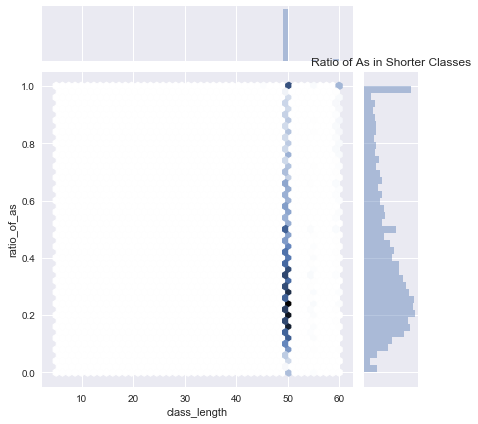

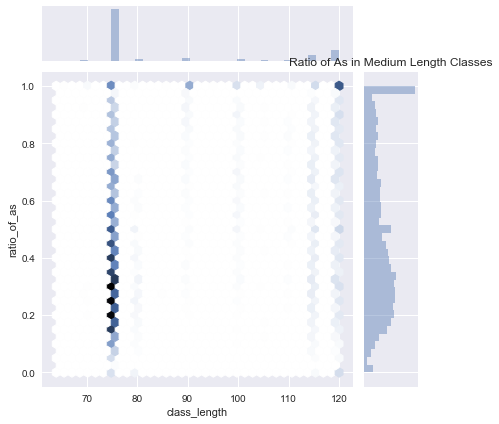

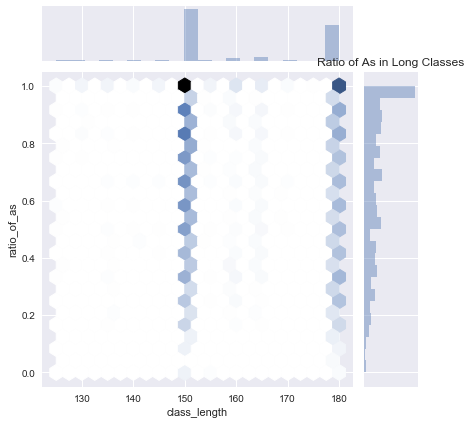

In [48]:
sns.jointplot('class_length', 'ratio_of_as',df_short, kind='hex')
plt.title('Ratio of As in Shorter Classes')
plt.show();
sns.jointplot('class_length', 'ratio_of_as',df_med, kind='hex')
plt.title('Ratio of As in Medium Length Classes')
plt.show();
sns.jointplot('class_length', 'ratio_of_as',df_long, kind='hex')
plt.title('Ratio of As in Long Classes')
plt.show();

# ANOVA Testing

Because we have several categories of length, we will use anova testing

In [49]:
df3 = df2.copy()
df3['short'] = df2['class_length'].between(1,60).apply(lambda x : int(x))
df3['med'] = df2['class_length'].between(61,120).apply(lambda x : int(x))
df3['long'] = df2['class_length'].between(121,180).apply(lambda x : int(x))
df3.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length,ratio_of_as,short,med,long
3,35,0,1,0,0,0,0,960,1010,LAB,36,50,0.972222,1,0,0
4,39,1,0,1,0,0,0,725,775,LAB,41,50,0.951220,1,0,0
5,32,2,1,1,0,0,0,595,645,LAB,36,50,0.888889,1,0,0
6,35,5,1,1,0,0,0,530,580,LAB,42,50,0.833333,1,0,0
7,34,0,3,3,0,0,0,530,580,LAB,40,50,0.850000,1,0,0


In [52]:
formula = "ratio_of_as ~ C(short) + C(med) + C(long)"
lm = ols(formula,df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq       df           F         PR(>F)
C(short)    23.399946      1.0  319.214429   3.088092e-71
C(med)       2.012132      1.0   27.448854   1.617676e-07
C(long)     45.078331      1.0  614.943890  3.591098e-135
Residual  5160.143899  70393.0         NaN            NaN


This ANOVA test demonstrates that class length, expsecially longer classes, may be influential. This test does not tell us how it impacts the percentage of A's yet, so we will now perform t-tests on the unique pairings.

# T-Tests: Determining Sample Size

Running t-tests on all pairs for further analysis:

In [53]:
moe = 0.1
z = 1.96 # z value for alpha 0.05
short_var = np.var(df_short['ratio_of_as'])
short_n = len(df_short['ratio_of_as'])
med_var = np.var(df_med['ratio_of_as'])
med_n = len(df_med['ratio_of_as'])
long_var = np.var(df_long['ratio_of_as'])
long_n = len(df_long['ratio_of_as'])


In [54]:
num = (short_n - 1) * short_var + (med_n - 1) * med_var + (long_n - 1) * long_var
den = short_n + med_n + long_n - 3
pooled_std = np.sqrt(num/den)

n = 2 * (z * pooled_std / moe)**2
n

55.51256087344818

We will use samples from short, med, and long of size 56.

In [80]:
np.random.seed(15)

short = df_short['ratio_of_as']
med = df_med['ratio_of_as']
long = df_long['ratio_of_as']

short_sample = np.random.choice(short, size=56)
med_sample = np.random.choice(med, size=56)
long_sample = np.random.choice(long, size=56)

In [81]:
print("Short vs Medium classes: " + str(stats.ttest_ind(short_sample, med_sample)))
print("Short vs Long classes: " + str(stats.ttest_ind(short_sample, long_sample)))
print("Medium vs Long classes: " + str(stats.ttest_ind(med_sample, long_sample)))

Short vs Medium classes: Ttest_indResult(statistic=0.05110564204883424, pvalue=0.9593340277668676)
Short vs Long classes: Ttest_indResult(statistic=-3.984777229948247, pvalue=0.00012174287732769673)
Medium vs Long classes: Ttest_indResult(statistic=-4.116904352666932, pvalue=7.450573030895581e-05)


When we compare these P-values to our alpha of 0.025 (0.05/2 for a two-tailed test) we can see there is a significant difference in the percentage of A's in classes longer than 2 hours when compared to other class lengths. This may also be influenced by longer classes meeting less days per week, so further research may be required. 